### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-07 12:42:55,701	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
popsize = 20
generations = 100
name = 'centered3'
#device = torch.device('mps:0')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, popsize=popsize)

[2023-02-07 12:42:56] INFO     <43965> evotorch.core: Instance of `Custom_NEProblem` (id:4363056896) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-07 12:42:56] INFO     <43965> evotorch.core: Instance of `Custom_NEProblem` (id:4363056896) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-07 12:42:56] INFO     <43965> evotorch.core: Instance of `Custom_NEProblem` (id:4363056896) -- The `device` of the problem is set as cpu
[2023-02-07 12:42:56] INFO     <43965> evotorch.core: Instance of `Custom_NEProblem` (id:4363056896) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-07 12:42:56] INFO     <43965> evotorch.core: Instance of `Custom_NEProblem` (id:4363056896) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0983)
    mean_eval : -157.46096801757812
  median_eval : -142.91827392578125
pop_best_eval : -0.09920647740364075
    best_eval : -0.09920647740364075
   worst_eval : -362.81793212890625

         iter : 2
     stepsize : ReadOnlyTensor(0.0968)
    mean_eval : -204.6953582763672
  median_eval : -166.83505249023438
pop_best_eval : 0.0
    best_eval : 0.0
   worst_eval : -440.6518859863281

         iter : 3
     stepsize : ReadOnlyTensor(0.0954)
    mean_eval : -159.10995483398438
  median_eval : -84.10847473144531
pop_best_eval : 0.004400588572025299
    best_eval : 0.004400588572025299
   worst_eval : -570.2797241210938

         iter : 4
     stepsize : ReadOnlyTensor(0.0941)
    mean_eval : -142.2230682373047
  median_eval : -140.85081481933594
pop_best_eval : 0.0
    best_eval : 0.004400588572025299
   worst_eval : -570.2797241210938

         iter : 5
     stepsize : ReadOnlyTensor(0.0929)
    mean_eval : -158.7493896484375
  med

In [ ]:
network = trainer.get_trained_network()

In [ ]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'])

#### Visualize trained network

In [ ]:
organism = generate_organism(10, device)
graph = organism.toGraph()
visualizer = Visualizer()

(2, 2)


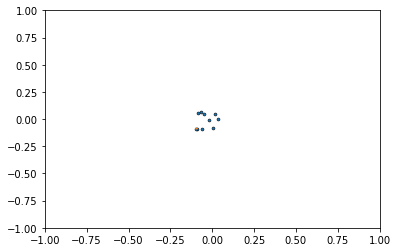

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


In [ ]:
anim = visualizer.animate_organism(graph, network, frames=100)
IPython.display.HTML(anim.to_jshtml())

In [ ]:
#anim.save('../animation/centered2.gif', writer='imagemagick', fps=10)
visualizer.save_animation_to_gif(anim, name, 10)

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>